In [1]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import torch
import os

In [2]:
def project_theta(theta, m_values, stack_axis=0):
    """
    Project given 2D vectors onto sin(m*theta) and cos(m*theta) for various m values.
    
    Parameters:
    vectors (np.ndarray): Array of shape (N, 2) representing N 2D vectors.
    m_values (list or np.ndarray): Array of m values for projection.
    
    Returns:
    projections (dict): Dictionary with m values as keys and the projected vectors as values.
                        Each projected vector is an array of shape (N, 2).
    """
    projections = []
    
    for m in m_values:
        sin_m_theta = torch.sin(m * theta)
        cos_m_theta = torch.cos(m * theta)
        
        # Form new vectors using the basis functions
        projected_vectors = torch.stack((cos_m_theta, sin_m_theta), axis=-1)
        
        projections.append(projected_vectors)
    
    return torch.stack(projections, axis=stack_axis)


In [3]:
def evaluate_functions_on_theta(theta, coefficients_list, m_values):
    """
    Evaluate the functions defined by coefficients for sin(m*theta) and cos(m*theta)
    on an image of a specific shape, centered at a given coordinate.

    Parameters:
    theta (torch.Tensor): Tensor of angles.
    coefficients_list (torch.Tensor): Tensor of shape (..., num_m_values, 2) with coefficients for sin and cos functions.
    m_values (torch.Tensor): Tensor of m values for the basis functions.

    Returns:
    torch.Tensor: Tensor of the evaluated function.
    """
    m_values = m_values.to(theta.dtype)
    m_theta = m_values.view(-1, 1, 1) * theta

    sin_m_theta = torch.sin(m_theta)
    cos_m_theta = torch.cos(m_theta)

    a_sin, a_cos = coefficients_list[..., 1], coefficients_list[..., 0]
    a_sin = a_sin.view(*a_sin.shape[:-1], -1, 1, 1)
    a_cos = a_cos.view(*a_cos.shape[:-1], -1, 1, 1)

    evaluated_function = (a_sin * sin_m_theta + a_cos * cos_m_theta).sum(dim=-3)
    
    return evaluated_function

In [4]:
def process_npz_files(folder_path):
    # List to store the numerical IDs
    id_list = []

    # List to store the NumPy arrays
    array_list = []

    # Loop through all files in the folder
    sorted_files = sorted(os.listdir(folder_path))
    
    for filename in sorted_files:
        if filename.endswith('.npz'):
            # Extract the numerical ID from the filename
            base_name = os.path.splitext(filename)[0]
            num_id = base_name.split('_')[-1]
            id_list.append(int(num_id))
            
            # Load the .npz file
            file_path = os.path.join(folder_path, filename)
            with np.load(file_path) as data:
                # Assume there's a single array in the .npz file
                array = list(data.values())[0]
                array_list.append(array)

    # Stack all arrays along the 0 axis
    stacked_array = np.stack(array_list, axis=0)

    return id_list, stacked_array

# Example usage
folder_path = 'images'  # Replace with your folder path
id_list, stacked_array = process_npz_files(folder_path)

print("List of IDs:", id_list)
print("Stacked array shape:", stacked_array.shape)


List of IDs: [111001, 111002, 111003, 111004, 111005, 111006, 111007, 111008, 111009, 111010, 111011, 111012, 111013, 111014, 111015, 111016, 111017, 111018, 111019, 111020, 111021, 111022, 111023, 111024, 111025, 111026, 111027, 111028, 111029, 111030, 111031, 111032, 111033, 111034, 111035, 111036, 111037, 111038, 111039, 111040, 111041, 111042, 111043, 111044, 111045, 111046, 111047, 111048, 111049, 111050, 111051, 111052, 111053, 111054, 111055, 111056, 111057, 111058, 111059, 111060, 111061, 111062, 111063, 111064, 111065, 111066, 111067, 111068, 111069, 111070, 111071, 111072, 111073, 111074, 111075, 111076, 111077, 111078, 111079, 111080, 111081, 111082, 111083, 111084, 111085, 111086, 111087, 111088, 111089, 111090, 111091, 111092, 111093, 111094, 111095, 111096, 111097, 111098, 111099, 111100]
Stacked array shape: (100, 3, 128, 128)


In [5]:
# Load data
data = stacked_array

# Split into theta and intensity

# atan2(y, x)
## ASSUMING THAT THETA IS SAME ACROSS EXAMPLES
data_theta = torch.atan2(torch.tensor(data[0, 1]), torch.tensor(data[0, 0]))
data_intensity = torch.tensor(data[:, 2])

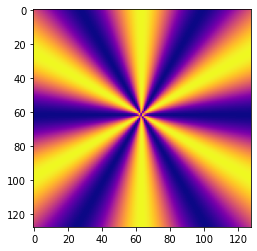

In [6]:
# Set of ms -- reduce for broader angles
# ms = torch.arange(36)
ms = torch.arange(12)

# six-fold signal
angles = torch.arange(0, 6) * 2 * torch.pi / 6.

# Projection onto circular harmonics (cos(m\theta), sin(m\theta))
projection = project_theta(angles, ms).sum(-2)

evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)
plt.imshow(evaluate_image_theta.detach(), cmap='plasma')

In [7]:
max_iter = 501

N = data_intensity.shape[0]

offset = torch.zeros(N, 1)
offset.requires_grad = True
opt = torch.optim.Adam([offset], lr=1e-2)

In [8]:
for i in range(max_iter):
    projection = project_theta(angles.reshape(1, -1) + offset, ms, stack_axis=1).sum(-2)
    evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)
    loss = -(data_intensity * evaluate_image_theta).sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i % 100 == 0:
        print(loss)
        print(offset.abs().max())

tensor(-1.5678e+08, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(0.0100, grad_fn=<MaxBackward1>)
tensor(-2.4267e+08, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(0.4002, grad_fn=<MaxBackward1>)
tensor(-2.4267e+08, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(0.4027, grad_fn=<MaxBackward1>)
tensor(-2.4267e+08, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(0.4028, grad_fn=<MaxBackward1>)
tensor(-2.4267e+08, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(0.4028, grad_fn=<MaxBackward1>)
tensor(-2.4267e+08, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(0.4028, grad_fn=<MaxBackward1>)


In [9]:
projection = project_theta(angles.reshape(1, -1) + offset, ms, stack_axis=1).sum(-2)
evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)

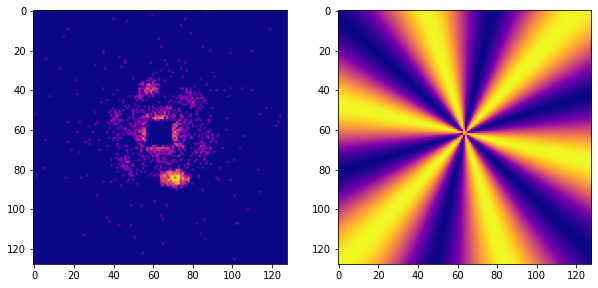

In [10]:
i = 50
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(np.sqrt(data_intensity[i].detach()), cmap='plasma')
ax[1].imshow(evaluate_image_theta[i].detach(), cmap='plasma')

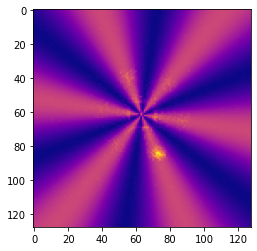

In [14]:
i = 24
plt.imshow(
    (evaluate_image_theta[i] / evaluate_image_theta[i].abs().max() + 
     data_intensity[i] / data_intensity[i].abs().max()).detach(), cmap='plasma')

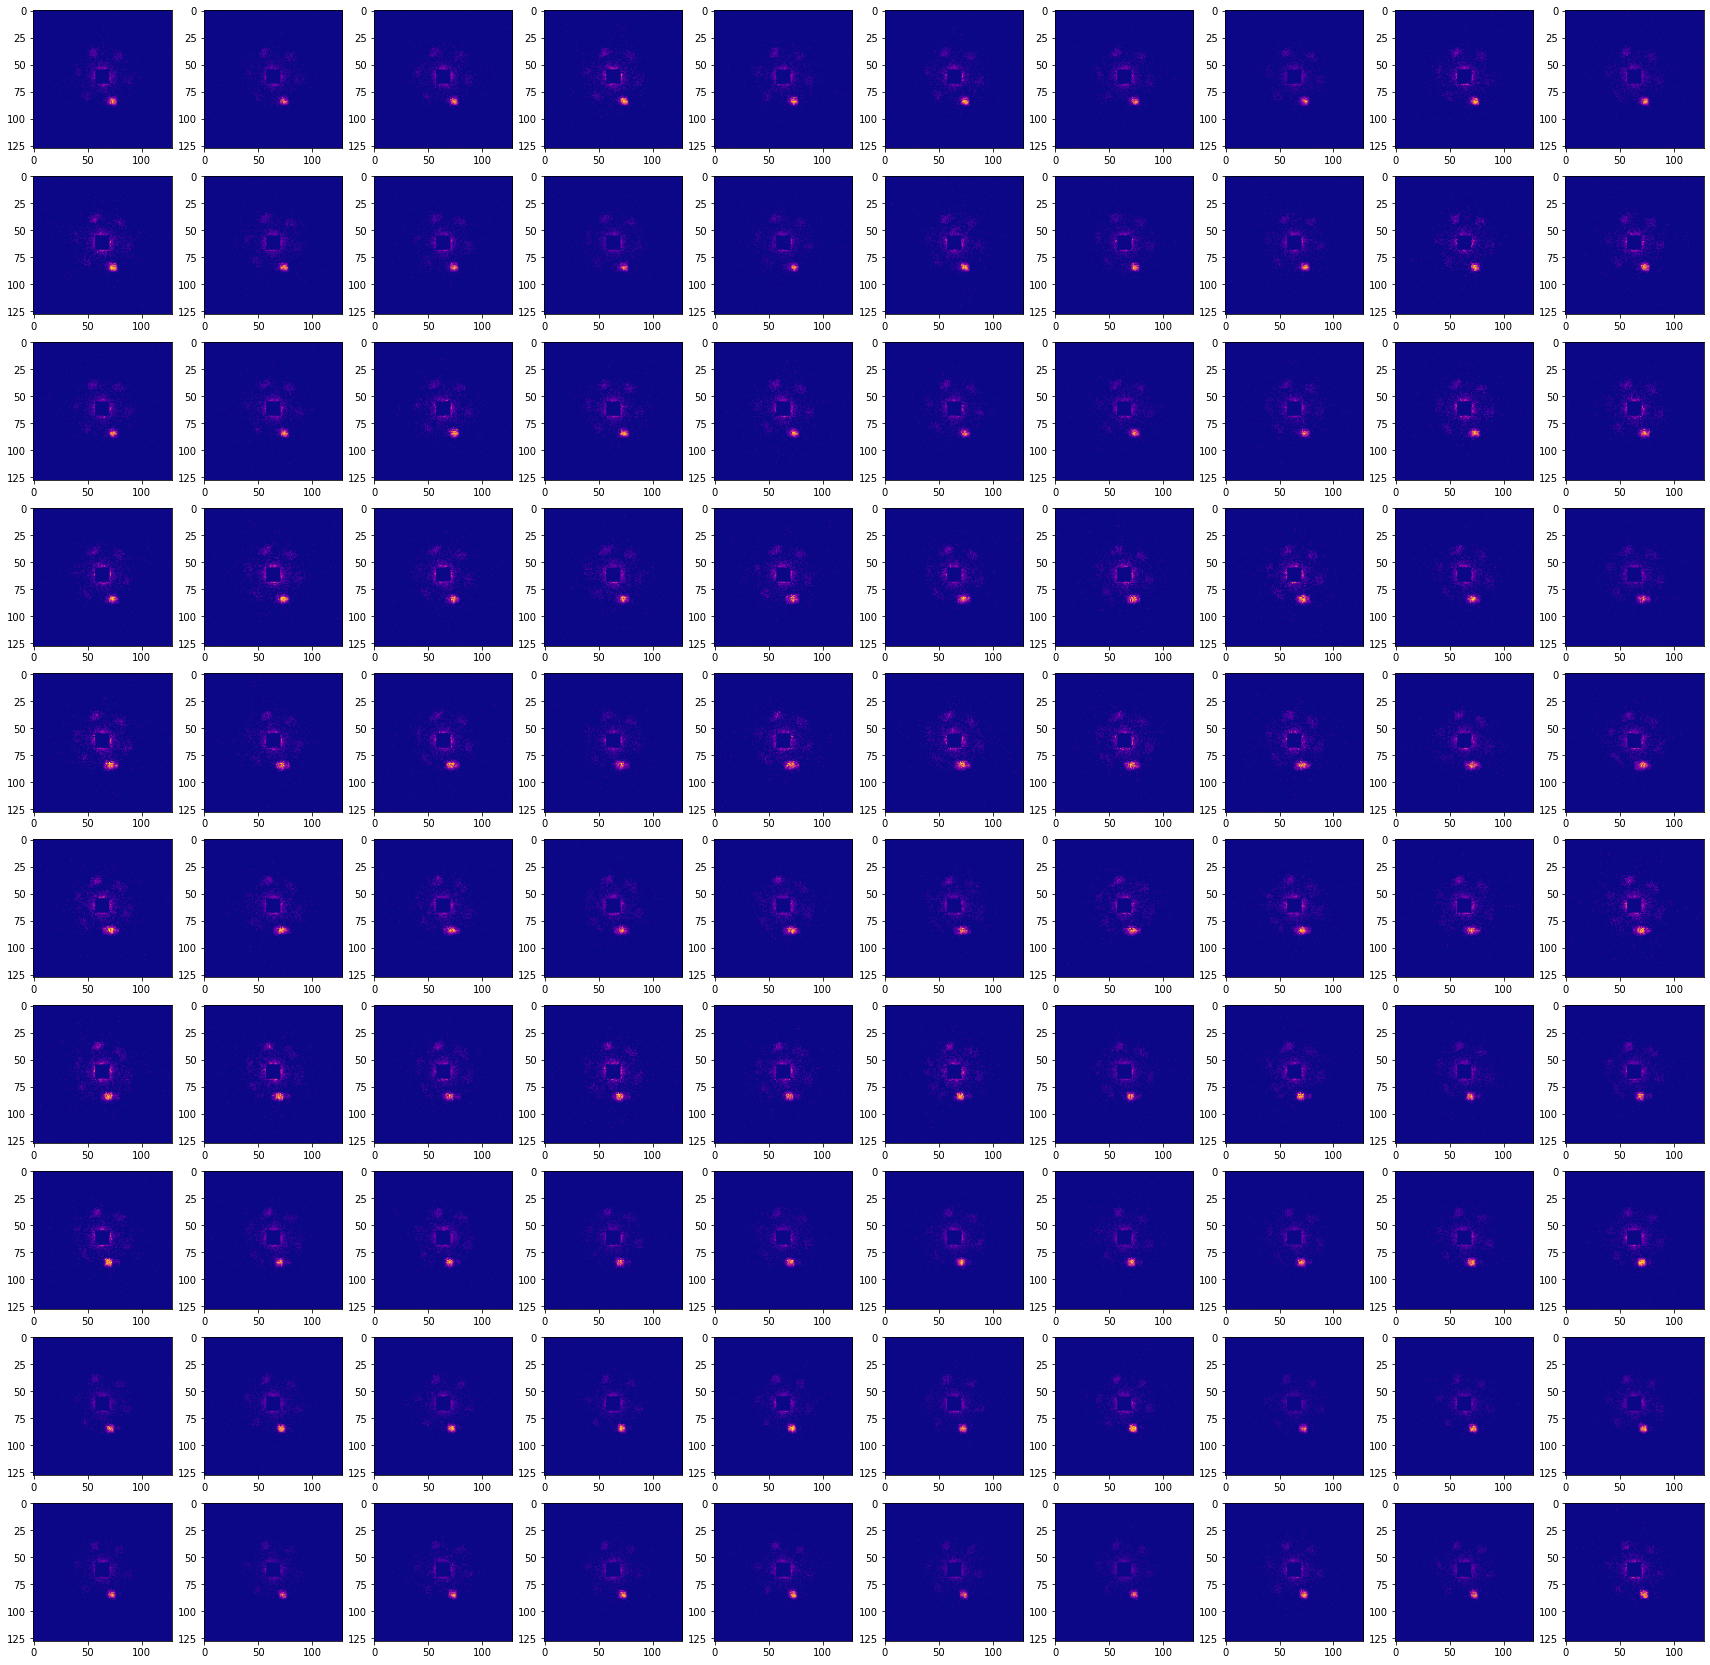

In [11]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(30, 30))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(data_intensity[i*10 + j], cmap='plasma')

In [ ]:
plt.hist(np.rad2deg(offset.detach().reshape(-1)).numpy(), bins=20);

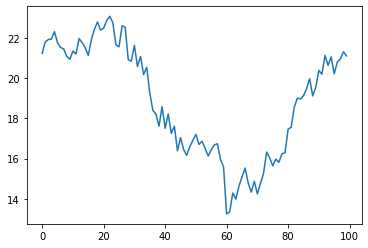

In [12]:
plt.plot(np.rad2deg(offset.detach().reshape(-1)).numpy())